**Date**: 2019-05-28

**Authors**: Adam Stafford

**Purpose**: To test whether we can predict enhancer function with new data.

**Background**:

After our old data lead to no progress, we are trying a new set of data, with only one species, Drosophila Melanogaster, as well as 9 transcription factor binding site motifs, to see if that will raise accuracy.

**Experiment**:

In [1]:
import pickle
import ast
import numpy as np
import matplotlib.pyplot as plt

Load the `pickle` buffered list:

In [2]:
with open("../../data/new_output_buffer.txt", "rb") as buff:
    seq_record_list2 = pickle.load(buff)

Creating the training and test sets.

In [4]:
#from random import shuffle
#shuffle(seq_record_list)

print(len(seq_record_list2))
seq_record_list = []
for i in range(0, len(seq_record_list2), 4):
    seq_record_list.append([seq_record_list2[i], seq_record_list2[i+1], seq_record_list2[i+2], seq_record_list2[i+3]])

28524


In [5]:
print(len(seq_record_list))

7131


In [7]:
validation2 = seq_record_list[(len(seq_record_list)-1000):]
training2 = seq_record_list[0:(len(seq_record_list)-1000)]
print(len(training2))
training = [training2[i] for i in range(0, len(training2))]
print(len(validation2))
validation = [validation2[i] for i in range(0, len(validation2))]
from random import shuffle
shuffle(validation)
shuffle(training)


6131
1000


In [8]:
print(seq_record_list[1])

['VT63732|0|dmel|-|2098', '0', 'dmel', [[0, 1, 0, 0, -7.555264949798584, -1.2992080450057983, -0.8725075721740723, -3.726209878921509, -4.518063068389893, -5.813533306121826, 0.9936271905899048, -0.1557808220386505, -4.529105186462402], [0, 0, 0, 1, -5.140227317810059, -1.8841705322265625, -6.396069526672363, 0.31561020016670227, -1.795596957206726, -4.813533306121826, -0.006372835021466017, -5.693904876708984, -6.114067554473877], [0, 0, 0, 1, 0.06922604143619537, -2.5216004848480225, -7.981031894683838, 1.0722581148147583, -0.43302688002586365, -3.1702721118927, -2.842874050140381, -2.1089425086975098, -3.7921395301818848], [0, 0, 1, 0, -0.9537003636360168, -2.106562852859497, 1.0019614696502686, 0.2600862383842468, 1.2892919778823853, -1.7623944282531738, -4.650228977203369, -1.945443868637085, 0.8517166376113892], [0, 0, 1, 0, -2.2016279697418213, -0.8841705322265625, -3.457470178604126, -0.6072219610214233, 0.30721384286880493, -2.813533306121826, 0.33466407656669617, -1.079195261

The following cell transforms the data into a format that is recognizable by the neural network model.

In [9]:
# A helper function to flatten a 2d list to 1d.
# Input: [[1, 2], [2, 3], [3, 4, 5]]
# Output: [1, 2, 2, 3, 3, 4, 5]
def flatten(lst):
    new_lst = []
    for sub_lst in lst:
        for item in sub_lst:
            new_lst.append(item)
    return new_lst

# A helper function to transform a lst so that its length becomes read_len by:
# 1. If len(lst) > read_len, curtail the end of the lst.
# 2. If len(lst) < read_len, keep extending the end of the lst with 0 (NA).
def curtail(lst, read_len):
    if len(lst) > read_len:
        lst = lst[:read_len]
    else:
        for i in range(read_len - len(lst)):
            lst.append([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    return lst

# Produce the train-test split
# length_read: the length that you want all DNA sequences to conform to
def prepare_input(training, test, length_read):
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    seq_count = 0
    while seq_count < len(training):
        X_train.append(flatten(curtail(training[seq_count][3], length_read)))
        y_train.append(int(training[seq_count][1]))
        seq_count += 1
    seq_count = 0
    while seq_count < len(test):
        X_test.append(flatten(curtail(test[seq_count][3], length_read)))
        y_test.append(int(test[seq_count][1]))
        seq_count += 1
    return X_train, y_train, X_test, y_test

# Turn list into numpy tensors that can directly feed into a neural network model
def to_np_array(X_train, y_train, X_test, y_test):
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    if len(y_train.shape) == 1:
        y_train = np.transpose(np.array([y_train]))
    X_test = np.array(X_test)
    y_test = np.transpose(np.array(y_test))
    if len(y_test.shape) == 1:
        y_test = np.transpose(np.array([y_test]))
    return X_train, y_train, X_test, y_test

In [10]:
X_train, y_train, X_test, y_test = prepare_input(training, validation, 1000)
X_train, y_train, X_test, y_test = to_np_array(X_train, y_train, X_test, y_test)
[X_train.shape, y_train.shape, X_test.shape, y_test.shape]


[(6131, 13000), (6131, 1), (1000, 13000), (1000, 1)]

In [11]:
# (X_train[0])[:10]

The following cells build a recurrent network with one bidirectional LSTM layer.

In [14]:
from keras.models import Model, Sequential
from keras.layers import Dense, CuDNNLSTM, Bidirectional

Using TensorFlow backend.


In [13]:
X_train_rnn = X_train.reshape(6131, 1000, 13)
X_test_rnn = X_test.reshape(1000, 1000, 13)

In [17]:
model = Sequential()
#model.add(CuDNNLSTM(8, input_shape=(1000, 8), return_sequences=True))
model.add(Bidirectional(CuDNNLSTM(16), input_shape=(1000, 13)))
#model.add(CuDNNLSTM(8, return_sequences=True))
#model.add(CuDNNLSTM(4, return_sequences=True))
#model.add(CuDNNLSTM(4))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train_rnn, y_train, epochs=20, batch_size=128, validation_data=(X_test_rnn, y_test))

Train on 6131 samples, validate on 1000 samples
Epoch 1/20
6131/6131 [==============================] - 11s 2ms/step - loss: 0.6933 - acc: 0.5252 - val_loss: 0.6791 - val_acc: 0.5470
Epoch 2/20
6131/6131 [==============================] - 10s 2ms/step - loss: 0.6812 - acc: 0.5374 - val_loss: 0.6729 - val_acc: 0.5430
Epoch 3/20
6131/6131 [==============================] - 10s 2ms/step - loss: 0.6765 - acc: 0.5431 - val_loss: 0.6705 - val_acc: 0.5520
Epoch 4/20
6131/6131 [==============================] - 10s 2ms/step - loss: 0.6747 - acc: 0.5547 - val_loss: 0.6728 - val_acc: 0.5340
Epoch 5/20
6131/6131 [==============================] - 10s 2ms/step - loss: 0.6727 - acc: 0.5581 - val_loss: 0.6723 - val_acc: 0.5370
Epoch 6/20
6131/6131 [==============================] - 10s 2ms/step - loss: 0.6715 - acc: 0.5634 - val_loss: 0.6746 - val_acc: 0.5340
Epoch 7/20
6131/6131 [==============================] - 10s 2ms/step - loss: 0.6703 - acc: 0.5666 - val_loss: 0.6725 - val_acc: 0.5230
Epoch 8

**Result**:

The following cell **visualize** the training/validation accuracies and losses over each epoch.

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('epoches')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('epoches')
plt.legend()

plt.show()

In [ ]:
Model_weights_path = '/home/ubuntu/data/data/Models/random_PWM_2019_04_25_weights.h5'
Model_json_path = "/home/ubuntu/data/data/Models/random_PWM_2019_04_25.json"

In [16]:
model.save_weights(Model_weights_path)
model_json = model.to_json()

file = open(Model_json_path, "w")
file.write(model_json)
file.close() 

OSError: Unable to create file (unable to open file: name = '/home/ubuntu/data/data/Models/random_PWM_2019_04_25_weights.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 242)

- The validation trend is not close to the training trend.

**Conclusion**:

- The result of the experiment shows the model does not predict accurately with the new data.


### False Discovery Rate

In [26]:
from keras.models import model_from_json

with open(Model_json_path, 'r') as f:
    model = model_from_json(f.read())

model.load_weights(Model_weights_path)


In [28]:
X_test_rnn = X_test.reshape(480, 1000, 8)
results = model.predict(X_test_rnn, batch_size=16)

false_positives = 0
true_positives = 0
total_negatives = 0
total_positives = 0
true_negatives = 0

for i in range(0,results.size):
    
    if results[i][0]>=0.5 and y_test[i]==0:
        false_positives += 1

    if results[i][0]>=0.5 and y_test[i]==1:
        true_positives += 1
        
    if results[i][0]<=0.5 and y_test[i]==0:
        true_negatives += 1
        
    if results[i][0] <= 0.5:
        total_negatives += 1
        
    if results[i][0] >= 0.5:
        total_positives += 1

false_discovery_rate = false_positives/(false_positives + true_positives)
print("The false discovery rate is: {}".format(false_discovery_rate))

The false discovery rate is: 0.5251396648044693


ROC Curve


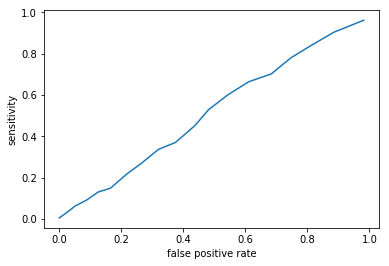

c-statistic = 0.49920460972850683


In [30]:
sensitivities = []
false_positive_rates =[]
discovery_percentage = 0.05

while discovery_percentage < 1.0:
    
    false_positives = 0
    true_positives = 0
    total_negatives = 0
    total_positives = 0
    true_negatives = 0
    
    for i in range(0,results.size):

        if results[i][0]>=discovery_percentage and y_train[i]==0:
            false_positives += 1

        if results[i][0]>=discovery_percentage and y_train[i]==1:
            true_positives += 1

        if results[i][0]<=discovery_percentage and y_train[i]==0:
            true_negatives += 1

        if y_train[i]==0:
            total_negatives += 1

        if y_train[i]==1:
            total_positives += 1
            
    if total_positives != 0 and total_negatives != 0:
        sensitivities.append(true_positives / total_positives)
        false_positive_rates.append(1-(true_negatives / total_negatives))
    
    discovery_percentage += 0.05
    
riemann = 0.0
for i in range(0,len(sensitivities) - 1):
    riemann += 0.5 * (sensitivities[i]+sensitivities[i+1]) * (false_positive_rates[i]-false_positive_rates[i+1])
    

print("ROC Curve")
plt.plot(false_positive_rates, sensitivities )
plt.ylabel('sensitivity')
plt.xlabel('false positive rate')
plt.show()
print("c-statistic = " + str(riemann))


This model is no better than predicting and outcome than random chance so the model does seem to be learning something. 